# Определение перспективного тарифа для телеком-компании "МЕГАЛАЙН"
Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
### Наименования столбцов по Таблицам:
<font color='red'> Таблица users (информация о пользователях):</font> <br>
user_id — уникальный идентификатор пользователя:<br>
first_name — имя пользователя<br>
last_name — фамилия пользователя<br>
age — возраст пользователя (годы)<br>
reg_date — дата подключения тарифа (день, месяц, год)<br>
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)<br>
city — город проживания пользователя<br>
tariff — название тарифного плана<br>
<font color='red'>Таблица calls (информация о звонках):</font><br>
id — уникальный номер звонка<br>
call_date — дата звонка<br>
duration — длительность звонка в минутах<br>
user_id — идентификатор пользователя, сделавшего звонок<br>
<font color='red'>Таблица messages (информация о сообщениях):</font><br>
id — уникальный номер сообщения<br>
message_date — дата сообщения<br>
user_id — идентификатор пользователя, отправившего сообщение<br>
<font color='red'>Таблица internet (информация об интернет-сессиях):</font><br>
id — уникальный номер сессии<br>
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)<br>
session_date — дата интернет-сессии<br>
user_id — идентификатор пользователя<br>
<font color='red'>Таблица tariffs (информация о тарифах):</font><br>
tariff_name — название тарифа<br>
rub_monthly_fee — ежемесячная абонентская плата в рублях<br>
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату<br>
messages_included — количество сообщений в месяц, включённых в абонентскую плату<br>
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)<br>
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)<br>
rub_per_message — стоимость отправки сообщения сверх тарифного пакета<br>
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)<br>

## Первичный анализ данных
Шаг первый. Открываем файлы и изучаем первичную информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math 
import seaborn as sns
import scipy.stats as st
calls_data = pd.read_csv('/datasets/calls.csv', parse_dates= ['call_date'])
internet_data = pd.read_csv('/datasets/internet.csv', parse_dates= ['session_date'] )
messages_data = pd.read_csv('/datasets/messages.csv', parse_dates= ['message_date'] )
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv')
calls_data.info()
internet_data.info()
messages_data.info()
tariffs_data.info()
users_data.info()
print(calls_data.duplicated().value_counts())
print(internet_data.duplicated().value_counts())
print(messages_data.duplicated().value_counts())
print(tariffs_data.duplicated().value_counts())
print(users_data.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int

Проводим первичный анализ данных. Видим, что даты имеют тип данных object, нужно привести данные к типу date.
Дубликатов не обнаружено. Пропущенные значения не удаляем, поскольку пользователи подключаются к тарифу и вызодят из него в разное время, удаление пропущенных значений может серьёзно навредить объективности анализа. 

# Обработка данных и расчет выручки

In [2]:
calls_data['duration'] = calls_data['duration'].apply(lambda x: math.ceil(x))
calls_data['month'] = calls_data['call_date'].dt.month#добавляем столбец с месяцем
month_calls_duration = calls_data.pivot_table(index=['user_id', 'month'], values='duration', aggfunc = 'sum')#строим сводную таблицу с мультииндексом
month_calls_duration.columns = ['calls_duration']
print('Таблица количества израсходованных минут по каждому пользователю в месяц:')
month_calls_duration


Таблица количества израсходованных минут по каждому пользователю в месяц:


calls_duration
user_id month                
1000    5                 159
        6                 172
        7                 340
        8                 408
        9                 466
...                       ...
1498    10                247
1499    9                  70
        10                449
        11                612
        12                492

[3174 rows x 1 columns]

Приводим данные по датам в таблицах в подходящий формат.  Округляем данные по звонкам до целых значений в бОльшую сторону, поскольку по правилам тарифа даже одна секунда считается как целая минута. Добавляем столбец с месяцем совершения звонка. Строим таблицу с длительностью звонков по каждому пользователю за каждый месяц.

In [3]:
print('Таблица количества звонков по каждому пользователю в месяц:')
month_calls = calls_data.pivot_table(index=['user_id','month'], values='id', aggfunc = 'count') #строим сводную таблицу по месяцам
month_calls.columns = ['calls']
month_calls

Таблица количества звонков по каждому пользователю в месяц:


calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
...              ...
1498    10        41
1499    9          9
        10        68
        11        74
        12        69

[3174 rows x 1 columns]

 Строим таблицу с количеством звонков по каждому пользователю за каждый месяц.

In [4]:
print('Таблица количества сообщений по каждому пользователю в месяц:')
messages_data['month'] = messages_data['message_date'].dt.month#добавляем стоец с месяцем к данным по сообщениям
month_messages = messages_data.pivot_table(index=['user_id','month'], values='id', aggfunc = 'count')#строим сводную таблицу  по отправленным сообщениям
month_messages.columns = ['messages']
month_messages


Таблица количества сообщений по каждому пользователю в месяц:


messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

Добавляем столбец с месяцем направления сообщения. Строим таблицу с количеством сообщения для каждого пользователя по месяцам.

In [5]:
print('Таблица количества трафика по каждому пользователю в месяц:')
internet_data['month'] = internet_data['session_date'].dt.month#добавляем столбец с номером месяца
month_internet = internet_data.pivot_table(index=['user_id','month'], values='mb_used', aggfunc = 'sum')#строим сводную таблицу по месяцам для интернет-трафика
month_internet = month_internet / 1024#делим количество использованных мегабайт в месяц на 1024, чтобы получить количество израсходованных Гб
month_internet = np.ceil(month_internet)#окргуляем количество Гб в большую сторону в соответствии с условиями Мегалайн
month_internet.columns = ['internet']
month_internet

Таблица количества трафика по каждому пользователю в месяц:


internet
user_id month          
1000    5           3.0
        6          23.0
        7          14.0
        8          14.0
        9          15.0
...                 ...
1498    10         21.0
1499    9           2.0
        10         18.0
        11         18.0
        12         13.0

[3203 rows x 1 columns]

Добавляем столбец с месяцем интернет-сессии. Округляем количество мегабайт в большую сторону согласно правилам тарифа. Строим таблицу с данными по интернет-трафику по каждому пользователю за каждый месяц.

In [6]:
mes_calls = month_calls.join(month_messages)

mes_calls_internet = mes_calls.join(month_internet)
calls_messages_internet_dur = mes_calls_internet.join(month_calls_duration) 
calls_messages_internet_dur.fillna(0, inplace = True)
calls_messages_internet_dur.head(10)
users_data.set_index(['user_id'])
for user_id in calls_messages_internet_dur.index:
    calls_messages_internet_dur.loc[user_id, 'tariff'] = users_data.loc[user_id[0]-1000, 'tariff']# честно говоря не до конца понял как работает часть user_id[0]-1000, вроде значение user_id в таблицах одинаковое, решение вопроса нашёл на кегле
for user_id in calls_messages_internet_dur.index:
    calls_messages_internet_dur.loc[user_id, 'city'] = users_data.loc[user_id[0]-1000, 'city']
calls_messages_internet_dur

calls  messages  internet  calls_duration tariff         city
user_id month                                                               
1000    5         22      22.0       3.0             159  ultra    Краснодар
        6         43      60.0      23.0             172  ultra    Краснодар
        7         47      75.0      14.0             340  ultra    Краснодар
        8         52      81.0      14.0             408  ultra    Краснодар
        9         58      57.0      15.0             466  ultra    Краснодар
...              ...       ...       ...             ...    ...          ...
1498    10        41      42.0      21.0             247  smart  Владикавказ
1499    9          9      11.0       2.0              70  smart        Пермь
        10        68      48.0      18.0             449  smart        Пермь
        11        74      59.0      18.0             612  smart        Пермь
        12        69      66.0      13.0             492  smart        Пермь

[3174 rows x 6 columns]

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера 2</b></font>

Да, такой способ соединения мы можем использовать в данном случае. Иначе в таблицу не попадут клиенты, которые не пользовались одним из видов услуг оператора в течение конкретного месяца. 

</div>

In [7]:
tariffs_data['gb_per_month_included'] = tariffs_data['mb_per_month_included'] / 1024
tariffs_data.drop(columns = ['mb_per_month_included'], inplace = True)
tariff_smart = tariffs_data.query('tariff_name == "smart"')
tariff_ultra = tariffs_data.query('tariff_name == "ultra"')
tariff_smart

,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,500,550,200,3,3,smart,15.0


In [8]:
def profit_month(row): #пишем фунцию для расчета помесячной прибыли с каждого пользователя
    
    calls_duration = row['calls_duration']
    messages = row['messages']
    gb_used = row['internet']
    tariff = row['tariff']
    calls = row['calls']
     
    if tariff == 'smart':
        extr_duration = calls_duration - tariff_smart.loc[0,'minutes_included']
        extr_gb = gb_used - tariff_smart.loc[0,'gb_per_month_included']
        extr_messages = messages - tariff_smart.loc[0,'messages_included']
 
        if extr_duration < 0: 
            extr_duration = 0
        if extr_gb < 0: 
            extr_gb = 0
        if extr_messages < 0: 
            extr_messages = 0
 
        return (tariff_smart.loc[0,'rub_per_message'] * extr_messages + 
                   tariff_smart.loc[0,'rub_per_gb'] * extr_gb + 
                   tariff_smart.loc[0,'rub_per_minute'] * extr_duration + 
                   tariff_smart.loc[0,'rub_monthly_fee']
                   ) 
 
    if tariff == 'ultra':
        extr_duration = calls_duration - tariff_ultra.loc[1,'minutes_included']
        extr_gb = gb_used - tariff_ultra.loc[1,'gb_per_month_included']
        extr_messages = messages - tariff_ultra.loc[1,'messages_included']
 
        if extr_duration < 0: 
                extr_duration = 0
        if extr_gb < 0: 
                extr_gb = 0
        if extr_messages < 0: 
                extr_messages = 0
 
        return (tariff_ultra.loc[1,'rub_per_message'] * extr_messages + 
                   tariff_ultra.loc[1,'rub_per_gb'] * extr_gb + 
                   tariff_ultra.loc[1,'rub_per_minute'] * extr_duration + 
                   tariff_ultra.loc[1,'rub_monthly_fee']
                   ) 
            
calls_messages_internet_dur['profit'] = calls_messages_internet_dur.apply(profit_month, axis=1)
full_data = calls_messages_internet_dur

Соединяем таблицы для наглядности и проведения расчетов. Создаем функцию для расчета выручки с каждого пользователя за каждый месяц. Присоедяем таблицу с расчетами.

In [15]:
full_data

calls  messages  internet  calls_duration tariff         city  \
user_id month                                                                  
1000    5         22      22.0       3.0             159  ultra    Краснодар   
        6         43      60.0      23.0             172  ultra    Краснодар   
        7         47      75.0      14.0             340  ultra    Краснодар   
        8         52      81.0      14.0             408  ultra    Краснодар   
        9         58      57.0      15.0             466  ultra    Краснодар   
...              ...       ...       ...             ...    ...          ...   
1498    10        41      42.0      21.0             247  smart  Владикавказ   
1499    9          9      11.0       2.0              70  smart        Пермь   
        10        68      48.0      18.0             449  smart        Пермь   
        11        74      59.0      18.0             612  smart        Пермь   
        12        69      66.0      13.0             492  smart        Пермь   

               profit  region  
user_id month                  
1000    5      1950.0  Регион  
        6      1950.0  Регион  
        7      1950.0  Регион  
        8      1950.0  Регион  
        9      1950.0  Регион  
...               ...     ...  
1498    10     1750.0  Регион  
1499    9       550.0  Регион  
        10     1150.0  Регион  
        11     1513.0  Регион  
        12      598.0  Регион  

[3174 rows x 8 columns]

# Анализ данных

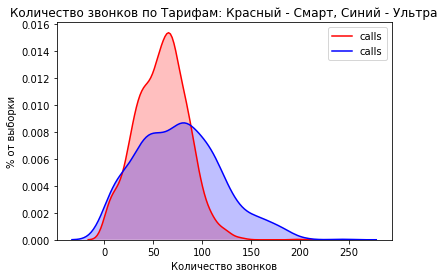

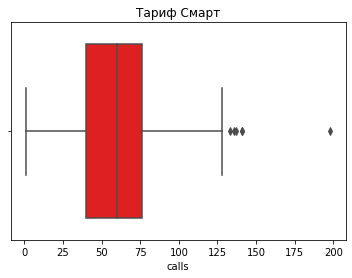

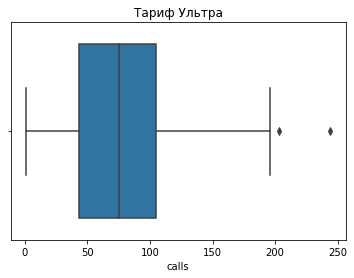

Основные показатели по звонкам для Тарифа Смарт count    2223.000000
mean       58.621233
std        25.796101
min         1.000000
25%        40.000000
50%        60.000000
75%        76.000000
max       198.000000
Name: calls, dtype: float64
Основные показатели по звонкам для Тарифа Ультра count    951.000000
mean      76.016824
std       42.403348
min        1.000000
25%       43.000000
50%       75.000000
75%      105.000000
max      244.000000
Name: calls, dtype: float64
Диспресия для тарифа Смарт: 665.4388289031333
Диспресия для тарифа Ультра: 1798.043927168078


In [9]:
smart_data = full_data.query('tariff == "smart"')
mean_data_smart = smart_data.pivot_table(index = ['user_id'],
                                         values = ['calls','messages', 'internet', 'calls_duration'], 
                                         aggfunc = 'mean')
ultra_data = full_data.query('tariff == "ultra"')
mean_data_ultra = ultra_data.pivot_table(index = ['user_id'],
                                         values = ['calls','messages', 'internet', 'calls_duration'], 
                                         aggfunc = 'mean')
#нашли средние значения для каждого пользователя по отдельным тарифам
fig = sns.kdeplot(smart_data['calls'], shade=True, color="r")
fig = sns.kdeplot(ultra_data['calls'], shade=True, color="b").set(title='Количество звонков по Тарифам: Красный - Смарт, Синий - Ультра',
                                                                  xlabel='Количество звонков',
                                                                  ylabel='% от выборки')

plt.show()
sns.boxplot(smart_data['calls'], color = "r").set(title = 'Тариф Смарт')
plt.show()
sns.boxplot(ultra_data['calls']).set(title = 'Тариф Ультра')
plt.show()
print ('Основные показатели по звонкам для Тарифа Смарт', smart_data['calls'].describe())
print ('Основные показатели по звонкам для Тарифа Ультра', ultra_data['calls'].describe())
print('Диспресия для тарифа Смарт:', smart_data['calls'].var())
print('Диспресия для тарифа Ультра:', ultra_data['calls'].var())


Выделяем таблицы для количества звонков и разделяем по тарифам. Находим средние значения. Строим гистограммы. Находим стандартные отклонения и дисперсии по тарифам. Наблюдаем, что пик ярко выражен у пользователей Тарифа Смарт, пользователи Тарифа Ультра совершают ожидаемо больше звонков.
Дисперсия и стандартное отклонение у тарифа Ультра также выше.

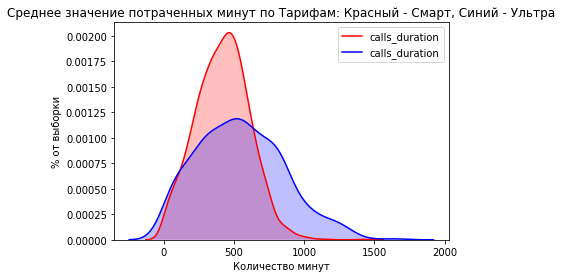

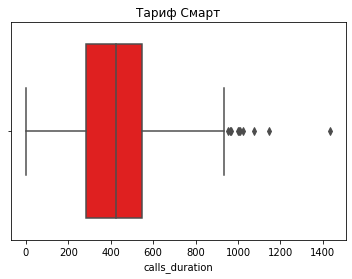

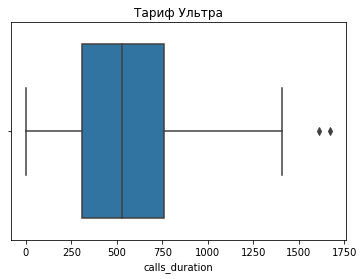

Основные показатели по количеству минут для Тарифа Смарт count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: calls_duration, dtype: float64
Основные показатели по количеству минут для Тарифа Ультра count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: calls_duration, dtype: float64
Диспресия для тарифа Смарт: 35844.1895513438
Диспресия для тарифа Ультра: 94203.41839614812


In [10]:
fig = sns.kdeplot(smart_data['calls_duration'], shade=True, color="r")
fig = sns.kdeplot(ultra_data['calls_duration'], shade=True, color="b").set(title='Среднее значение потраченных минут по Тарифам: Красный - Смарт, Синий - Ультра',
                                                                  xlabel='Количество минут',
                                                                  ylabel='% от выборки')

plt.show()
sns.boxplot(smart_data['calls_duration'], color = "r").set(title = 'Тариф Смарт')
plt.show()
sns.boxplot(ultra_data['calls_duration']).set(title = 'Тариф Ультра')
plt.show()
print ('Основные показатели по количеству минут для Тарифа Смарт', smart_data['calls_duration'].describe())
print ('Основные показатели по количеству минут для Тарифа Ультра', ultra_data['calls_duration'].describe())
print('Диспресия для тарифа Смарт:', smart_data['calls_duration'].var())
print('Диспресия для тарифа Ультра:', ultra_data['calls_duration'].var())

 Находим средние значения и  строим графики и ящики с усами. Находим стандартные отклонения и дисперсии по тарифам. Наблюдаем, что пик ярко выражен опять же у пользователей Тарифа Смарт, пользователи Тарифа Ультра тратят больше минут на разговоры. Также тариф Смарт показывает гораздо большее значение выбросов данных, возможно пользователи не знают о тарифе, включающем большее количество минут и платят за экстра-минуты.
Дисперсия и стандартное отклонение у тарифа Ультра также выше.

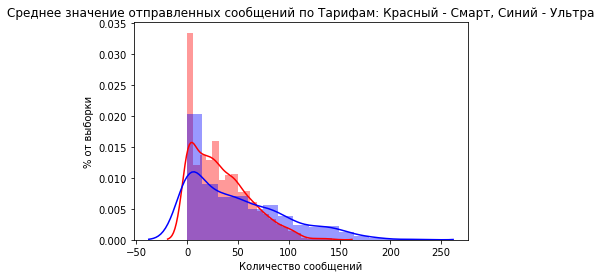

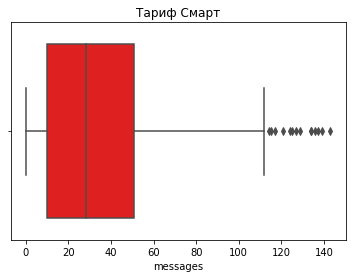

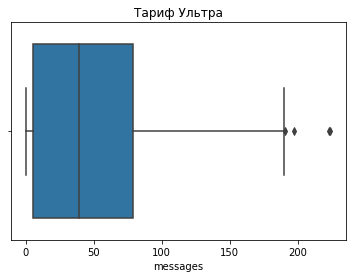

Основные показатели по количеству минут для Тарифа Смарт count    2223.000000
mean       33.396311
std        28.259437
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64
Основные показатели по количеству минут для Тарифа Ультра count    951.000000
mean      49.033649
std       46.890656
min        0.000000
25%        5.000000
50%       39.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64
Диспресия для тарифа Смарт: 798.5957919678608
Диспресия для тарифа Ультра: 2198.7336034091536


In [11]:
fig = sns.distplot(smart_data['messages'], color="r")
fig = sns.distplot(ultra_data['messages'], color="b").set(title='Среднее значение отправленных сообщений по Тарифам: Красный - Смарт, Синий - Ультра',
                                                                  xlabel='Количество сообщений',
                                                                  ylabel='% от выборки')

plt.show()
sns.boxplot(smart_data['messages'], color = "r").set(title = 'Тариф Смарт')
plt.show()
sns.boxplot(ultra_data['messages']).set(title = 'Тариф Ультра')
plt.show()
print ('Основные показатели по количеству минут для Тарифа Смарт', smart_data['messages'].describe())
print ('Основные показатели по количеству минут для Тарифа Ультра', ultra_data['messages'].describe())
print('Диспресия для тарифа Смарт:', smart_data['messages'].var())
print('Диспресия для тарифа Ультра:', ultra_data['messages'].var())

 Строим гистограммы и ящики с усами. Наблюдаем, что пик у обоих тарифов наблюдается в районе 0 сообщений, большинство пользователей вообще не пользуются сообщениями. Пользователи тарифа Ультра, отправляют больше сообщений, средние и медианные показатели существенно выше, чем у пользователей Смарта. Снова наблюдаем большое количество выбросов у тарифа Смарт. Стандартное отклонениие и дисперсия, соответственно, выше у Ультра.

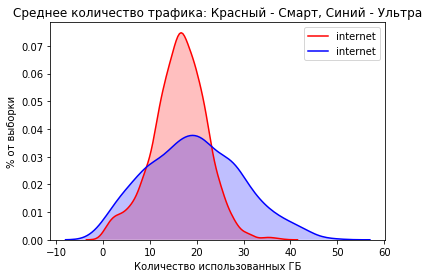

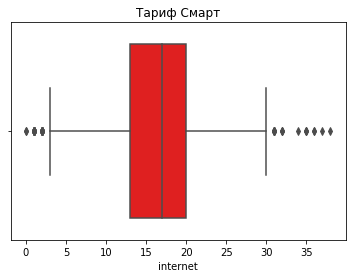

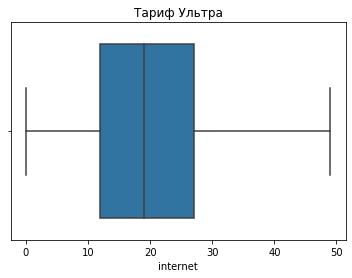

Основные показатели по использованному трафику для Тарифа Смарт count    2223.000000
mean       16.329735
std         5.752599
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: internet, dtype: float64
Основные показатели по  использованному трафику для Тарифа Ультра count    951.000000
mean      19.487907
std        9.890432
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: internet, dtype: float64
Диспресия для тарифа Смарт: 33.09239628416283
Диспресия для тарифа Ультра: 97.82064309037578


In [12]:
fig = sns.kdeplot(smart_data['internet'], shade=True, color="r")
fig = sns.kdeplot(ultra_data['internet'], shade=True, color="b").set(title='Среднее количество трафика: Красный - Смарт, Синий - Ультра',
                                                                  xlabel='Количество использованных ГБ',
                                                                  ylabel='% от выборки')

plt.show()
sns.boxplot(smart_data['internet'], color = "r").set(title = 'Тариф Смарт')
plt.show()
sns.boxplot(ultra_data['internet']).set(title = 'Тариф Ультра')
plt.show()
print ('Основные показатели по использованному трафику для Тарифа Смарт', smart_data['internet'].describe())
print ('Основные показатели по  использованному трафику для Тарифа Ультра', ultra_data['internet'].describe())
print('Диспресия для тарифа Смарт:', smart_data['internet'].var())
print('Диспресия для тарифа Ультра:', ultra_data['internet'].var())

 Строим гистограммы и ящики с усами. Наблюдаем, что средние показатели у Тарифов отличаются не так сильно, как в случае со звонками и сообщениями. Пользователи тарифа Ультра ожидаемо тратят больше трафика, однако их показатели распределены более равномерно, околонулевые значения у пользователей Смарта являются выбросами, можно предположить, что так пользователи, пользуясь мессенджерами, пытаются экономить на звонках и сообщениях. Снова наблюдаем большое количество выбросов у тарифа Смарт. Стандартное отклонениие и дисперсия, соответственно, выше у Ультра.

# Проверка гипотез
H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

α=1% Статистическую значимость принимаем за 1%.


In [13]:

ultra = full_data.query('tariff == "ultra"')['profit']
smart = full_data.query('tariff == "smart"')['profit']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)#проводим независимый т-тест, зная что дисперсия отличается, параменту equal_var присваимваем значение False

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):#сравниваем p-value со статистической значимостью
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Медианная общая выручка по тарифам:',full_data.pivot_table(index='tariff', values='profit', aggfunc='median'))
print('Средняя общая выручка по тарифам:',full_data.pivot_table(index='tariff', values='profit', aggfunc='mean'))

p-значение: 3.155173205867294e-245
Отвергаем нулевую гипотезу
Медианная общая выручка по тарифам:         profit
tariff        
smart   1030.0
ultra   1950.0
Средняя общая выручка по тарифам:              profit
tariff             
smart   1290.891138
ultra   2070.977918


Исходя из проверки значения p_value делаем вывод, что выручка с тарифов не одинаковая, исходя из имеющихся данных, медианная и средняя отличаются почти  в два раза, что и было подтверждено т-тестом.


H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

α=1%

In [14]:
moscow = full_data.query('city == "Москва"')['profit']
regions = full_data.query('city != "Москва"')['profit']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):#сравниваем p-value со статистической значимостью
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
def pick_region(city):# пишем функцию с распеределением данных на Москву и остальные регионы.
    if city == 'Москва': return 'Москва'
    else: return 'Регион'
    
full_data['region'] = full_data['city'].apply(pick_region)#применяем фунцию к датасету
print('Медианная общая выручка по Регионам:', full_data.pivot_table(index='region', values='profit', aggfunc='median'))
print('Средняя общая выручка по Регионам:', full_data.pivot_table(index='region', values='profit', aggfunc='mean'))

p-значение: 0.4619932225305272
Не получилось отвергнуть нулевую гипотезу
Медианная общая выручка по Регионам:         profit
region        
Москва  1750.0
Регион  1553.5
Средняя общая выручка по Регионам:              profit
region             
Москва  1546.052459
Регион  1519.523791


У нас не получилось отвергнуть нашу нулевую гипотезу, значит делаем предположение, что выручка пользователей из Москвы и из других регионов не отличается. Проверяем медианные и средние значения выручки исходя из региона и подтверждаем наше предположение: выручка отличается незначительно.

# Общий вывод
По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем Мегалайн от одного пользователя в месяц получает 2070 рублей и 1290 рублей соответственно. 
Учитывая ежемесячную стоимость тарифа Смарт в 550 рублей, пользователи Смарта гораздо больше выходят за пределы включенных минут, сообщений и трафика. Это объясняет более выделяющиеся пики показателей: пользователи сознательно себя ограничивают в объеме используемых услуг. Показатели пользователей тарифа Ультра распределены равномерно, что означает, что они меньше задумываются об объеме пользуемых услуг.
Проверка гипотезы о равенстве выручки с тарифов позволяет нам сделать вывод о неравестве выручки с тарифов.
Кроме того была проверена гипотеза о равенстве выручки в Москве и остальных регионах, что получило подтверждение в Т-тесте: выручка отличается незначительно.